# Tutorial

In [1]:
import os
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop # Or legacy: from tensorflow.keras.optimizers.legacy import RMSprop if needed
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [2]:
!wget --no-check-certificate "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" -O "/tmp/cats-and-dogs.zip"

--2025-03-27 19:12:31--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.218.186.12, 2600:1409:9800:1390::317f, 2600:1409:9800:138e::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.218.186.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  94.1MB/s    in 7.7s    

2025-03-27 19:12:39 (102 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [3]:
def get_valid(file_path):
    correct_files = []
    for name in os.listdir(file_path):
        try:
            img = Image.open(file_path + "/" + name)
            correct_files.append(name)
        except UnidentifiedImageError:
            pass
    return correct_files

In [4]:
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
classes = ['Cat', 'Dog']
original_cat_path = '/tmp/PetImages/Cat'
original_dog_path = '/tmp/PetImages/Dog'
original_cat = get_valid(original_cat_path)
original_dog = get_valid(original_dog_path)
random.seed(101)

random.shuffle(original_cat)
random.shuffle(original_dog)
size = min(len(original_cat), len(original_dog))
train_size = int(np.floor(0.7 * size))

valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size
base_directory = 'dataset'
os.mkdir(base_directory)
type_datasets = ['train', 'valid', 'test']
directories = {}

for type_dataset in type_datasets:
    directory = os.path.join(base_directory, type_dataset)
    os.mkdir(directory)
    for name_class in classes:
        animal = os.path.join(directory, name_class)
        os.mkdir(animal)
        directories[f'{type_dataset}_{name_class}'] = animal+'/'
index = 0

for name_cat, name_dog in zip(original_cat, original_dog):
        if index <= train_size:
            type_of_dataset = 'train'
        elif train_size < index <= (train_size + valid_size):
            type_of_dataset = 'valid'
        elif (train_size + valid_size) < index <= (train_size + valid_size + test_size):
            type_of_dataset = 'test'
        shutil.copyfile(src=(original_cat_path + '/' +name_cat), dst=(directories[f'{type_of_dataset}_Cat']+name_cat))
        shutil.copyfile(src=(original_dog_path + '/' + name_dog), dst=(directories[f'{type_of_dataset}_Dog']+name_dog))
        index += 1

print(f'Dog - train: {len(os.listdir(directories["train_Dog"]))}\tCat - train: {len(os.listdir(directories["train_Cat"]))}')
print(f'Dog - valid: {len(os.listdir(directories["valid_Dog"]))}\tCat - valid: {len(os.listdir(directories["valid_Cat"]))}')
print(f'Dog - test:  {len(os.listdir(directories["test_Dog"]))}\tCat - test:  {len(os.listdir(directories["test_Cat"]))}')

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Dog - train: 8750	Cat - train: 8750
Dog - valid: 2499	Cat - valid: 2499
Dog - test:  1250	Cat - test:  1250


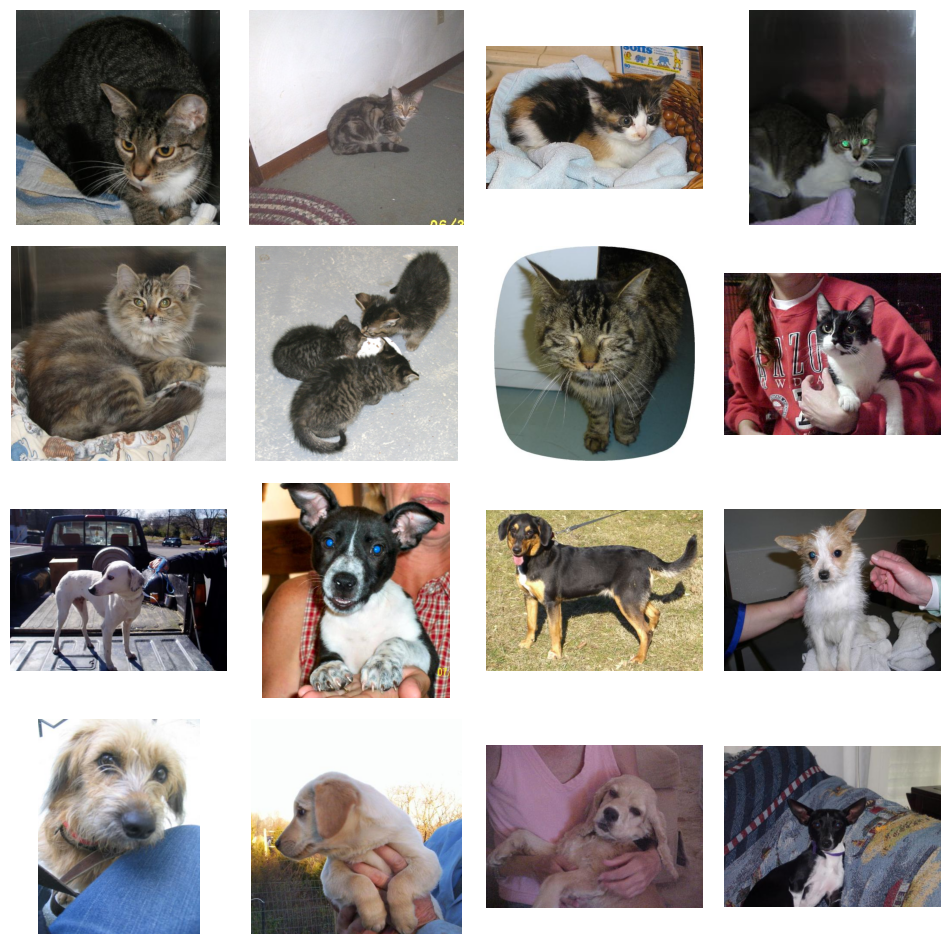

In [5]:
fig = plt.figure(figsize = (12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, element in enumerate(os.listdir(os.path.join(directories["train_Cat"]))[:8]):
    ax = fig.add_subplot(4, 4, i+1)
    img = Image.open(directories["train_Cat"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

for i, element in enumerate(os.listdir(os.path.join(directories["train_Dog"]))[:8]):
    ax = fig.add_subplot(4, 4, i+9)
    img = Image.open(directories["train_Dog"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [6]:
img_width, img_height = 150, 150
train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/valid/'
epochs = 1000
batch_size = 64
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size
patience = 5
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size, class_mode='binary')
train_datagen_augmentation = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=30,
                                   horizontal_flip=True)
train_generator_augmentation = train_datagen_augmentation.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')

Found 17500 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 17500 images belonging to 2 classes.


In [7]:
models = []
os.mkdir("history")
os.mkdir("charts")

In [8]:
model_baseline = Sequential()
model_baseline.add(Flatten(input_shape=(150, 150, 3)))
model_baseline.add(Dense(units=1, activation='sigmoid'))
model_baseline.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_baseline.summary()
models.append("baseline")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          67,501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,501 (263.68 KB)

 Trainable params: 67,501 (263.68 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
es = EarlyStopping(patience=patience, monitor='val_accuracy', restore_best_weights=True)

In [10]:
history_baseline = model_baseline.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])
history_baseline_df = pd.DataFrame(history_baseline.history)
history_baseline_csv_file = 'history/history_baseline.csv'

with open(history_baseline_csv_file, mode='w') as f:
    history_baseline_df.to_csv(f)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.5066 - loss: 1.1153 - val_accuracy: 0.5361 - val_loss: 0.7217
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.5165 - loss: 0.9043 - val_accuracy: 0.4976 - val_loss: 1.0806
Epoch 3/1000
  1/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5781 - loss: 0.8912

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6014 - loss: 0.7745 - val_accuracy: 0.5729 - val_loss: 0.6780
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.5228 - loss: 0.8951 - val_accuracy: 0.5076 - val_loss: 0.7985
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.5110 - loss: 0.9356 - val_accuracy: 0.5288 - val_loss: 0.7866
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5622 - loss: 0.7963 - val_accuracy: 0.5593 - val_loss: 0.6976
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 56s 135ms/step - accuracy: 0.5114 - loss: 0.9183 - val_accuracy: 0.5032 - val_loss: 1.0881
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.5383 - loss: 0.9043 - val_accuracy: 0.5076 - val_loss: 1.1852


In [11]:
model_simple_1 = Sequential()
model_simple_1.add(Conv2D(filters=10, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model_simple_1.add(MaxPooling2D(2, 2))
model_simple_1.add(Flatten())
model_simple_1.add(Dense(units=1, activation='sigmoid'))
model_simple_1.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_1.summary()
models.append("simple_1")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 54760)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          54,761 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,041 (215.00 KB)

 Trainable params: 55,041 (215.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history_simple_1 = model_simple_1.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])

history_simple_1_df = pd.DataFrame(history_simple_1.history)
history_simple_1_csv_file = 'history/history_simple_1.csv'

with open(history_simple_1_csv_file, mode='w') as f:
    history_simple_1_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.7749 - loss: 0.4947 - val_accuracy: 0.6911 - val_loss: 0.6058
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.7834 - loss: 0.4732 - val_accuracy: 0.7091 - val_loss: 0.5682
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7497 - loss: 0.4953 - val_accuracy: 0.7007 - val_loss: 0.5780
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.8011 - loss: 0.4421 - val_accuracy: 0.7067 - val_loss: 0.5802
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.8137 - loss: 0.4334 - val_accuracy: 0.7232 - val_loss: 0.5762
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7969 - loss: 0.4518 - val_accuracy: 0.7248 - val_loss: 0.5616
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.8329 - loss: 0.3979 - val_accuracy: 0.7256 - val_loss: 0.5639
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.84

In [14]:
model_simple_2 = Sequential()
model_simple_2.add(Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model_simple_2.add(MaxPooling2D(2, 2))
model_simple_2.add(Flatten())
model_simple_2.add(Dense(units=1, activation='sigmoid'))
model_simple_2.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_2.summary()
models.append("simple_2")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 75, 75, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 56250)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │          56,251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,531 (220.82 KB)

 Trainable params: 56,531 (220.82 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_simple_2 = model_simple_2.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])

history_simple_2_df = pd.DataFrame(history_simple_2.history)
history_simple_2_csv_file = 'history/history_simple_2.csv'

with open(history_simple_2_csv_file, mode='w') as f:
    history_simple_2_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.5495 - loss: 0.9215 - val_accuracy: 0.6687 - val_loss: 0.6118
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 0.6974 - loss: 0.5716 - val_accuracy: 0.6815 - val_loss: 0.5969
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7112 - loss: 0.5652 - val_accuracy: 0.6847 - val_loss: 0.5725
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.7326 - loss: 0.5292 - val_accuracy: 0.7224 - val_loss: 0.5540
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.7728 - loss: 0.4863 - val_accuracy: 0.7232 - val_loss: 0.5612
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7734 - loss: 0.4522 - val_accuracy: 0.7175 - val_loss: 0.5581
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 57s 136ms/step - accuracy: 0.7859 - loss: 0.4634 - val_accuracy: 0.7260 - val_loss: 0.5470
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.80

In [16]:
model_3 = Sequential()

# Block 1
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Flatten())
model_3.add(Dropout(0.5))
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(units=1, activation='sigmoid'))
model_3.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_3.summary()
models.append("model_3")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history_model_3 = model_3.fit(train_generator_augmentation,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_3_df = pd.DataFrame(history_model_3.history)
history_model_3_csv_file = 'history/history_model_3.csv'
with open(history_model_3_csv_file, mode='w') as f:
    history_model_3_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 74s 463ms/step - accuracy: 0.5036 - loss: 0.6933 - val_accuracy: 0.5084 - val_loss: 0.6912
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 79s 585ms/step - accuracy: 0.5267 - loss: 0.6908 - val_accuracy: 0.5621 - val_loss: 0.6804
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5779 - loss: 0.6811 - val_accuracy: 0.5329 - val_loss: 0.6828
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 108s 450ms/step - accuracy: 0.5728 - loss: 0.6762 - val_accuracy: 0.5841 - val_loss: 0.6746
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 60s 445ms/step - accuracy: 0.5910 - loss: 0.6646 - val_accuracy: 0.5849 - val_loss: 0.6740
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5310 - loss: 0.7305 - val_accuracy: 0.6154 - val_loss: 0.6483
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 60s 443ms/step - accuracy: 0.5995 - loss: 0.6556 - val_accuracy: 0.6186 - val_loss: 0.6634
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 81s 602ms/step - accuracy: 0.6

In [19]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg16.trainable = True

set_trainable = False
for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in vgg16.layers:
    print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

model_4 = Sequential()
model_4.add(vgg16)
model_4.add(Flatten())
model_4.add(Dropout(0.5))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(units=1, activation='sigmoid'))
model_4.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_4.summary()
models.append("model_4")


layer_name: input_layer_6 trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,845,121 (64.26 MB)

 Trainable params: 9,209,857 (35.13 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [20]:
history_model_4 = model_4.fit(train_generator_augmentation,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_4_df = pd.DataFrame(history_model_4.history)
history_model_4_csv_file = 'history/history_model_4.csv'
with open(history_model_4_csv_file, mode='w') as f:
    history_model_4_df.to_csv(f)

Epoch 1/1000
110/136 ━━━━━━━━━━━━━━━━━━━━ 14s 542ms/step - accuracy: 0.7057 - loss: 0.5564

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 100s 605ms/step - accuracy: 0.7243 - loss: 0.5307 - val_accuracy: 0.9131 - val_loss: 0.2097
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 80s 593ms/step - accuracy: 0.8797 - loss: 0.2729 - val_accuracy: 0.9355 - val_loss: 0.1672
Epoch 3/1000
  2/136 ━━━━━━━━━━━━━━━━━━━━ 28s 215ms/step - accuracy: 0.9492 - loss: 0.2000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.9300 - loss: 0.2441 - val_accuracy: 0.9335 - val_loss: 0.1653
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 82s 602ms/step - accuracy: 0.9114 - loss: 0.2146 - val_accuracy: 0.9359 - val_loss: 0.1667
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 82s 604ms/step - accuracy: 0.9198 - loss: 0.1919 - val_accuracy: 0.9355 - val_loss: 0.1982
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9141 - loss: 0.1958 - val_accuracy: 0.9163 - val_loss: 0.2254
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 101s 519ms/step - accuracy: 0.9281 - loss: 0.1824 - val_accuracy: 0.9271 - val_loss: 0.1880
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 82s 605ms/step - accuracy: 0.9337 - loss: 0.1689 - val_accuracy: 0.9471 - val_loss: 0.1308
Epoch 9/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9608 - loss: 0.1348 - val_accuracy: 0.9563 - val_loss: 0.1363
Epoch 10/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 82s 602ms/step - accuracy: 0.9404 - loss: 0